# Эксперименты с автоэнкодером

Как мне кажется, предложенный задача очень походит на Video Highlight Detection (выделение важного фрагмента видео, используется для выбора момента для превью видеоконтента), по которой начиная с примерно с 2016 и по настоящее время публикуется достаточно много исследований (распространенный подход - CNN внутри кадра и RNN по времени, т.к. важное собите может быть не в статике, а в изменении) и которая вполне имеет применение в реальных проектах (насколько знаю, например, в Mail.ru), но она решается как supervised, а у нас таргета нет.

Поэтому пробуем сделать в качестве фич для модели более высокого уровня сжатый слой используя автоэнкодер (unsupervised).

In [2]:
import cv2
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision

import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

In [3]:
pic_size = 224 # размер кадра
batch_size = 8
epochs = 30
latent_dims = 2 # можно подобрать минимальную размерность, которая всё еще будет передавать много сигнала

frames = 'frames/'
video_file = 'F1_1_1_1.ts'

torch.manual_seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# преобразуем видео в кадры для обучения

!rm -rf $frames
!mkdir $frames
!mkdir $frames/$video_file

vidcap = cv2.VideoCapture(video_file)
success, image = vidcap.read()
count = 0

while success:
  cv2.imwrite(frames + str(video_file) + "/%d.jpg" % count, image)       
  success,image = vidcap.read()
  count += 1

In [5]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(pic_size ** 2, 512)
        self.linear2 = nn.Linear(512, latent_dims)
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

In [6]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, pic_size ** 2)
        
    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, pic_size, pic_size))

In [7]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [8]:
def train(autoencoder, data, epochs=epochs):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
    return autoencoder

In [9]:
image_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((pic_size, pic_size)),
    torchvision.transforms.Grayscale(),
    torchvision.transforms.ToTensor(),
    ])

In [10]:
latent_dims = latent_dims
autoencoder = Autoencoder(latent_dims).to(device)

data = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(frames, transform=image_transforms),
        batch_size=batch_size,
        shuffle=True)

autoencoder = train(autoencoder, data)

100%|██████████| 30/30 [08:38<00:00, 17.29s/it]


Посмотрим, как латентные фичи разнесло по пространству

In [11]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

In [12]:
plot_latent(autoencoder, data)

In [13]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = pic_size
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(pic_size, pic_size).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

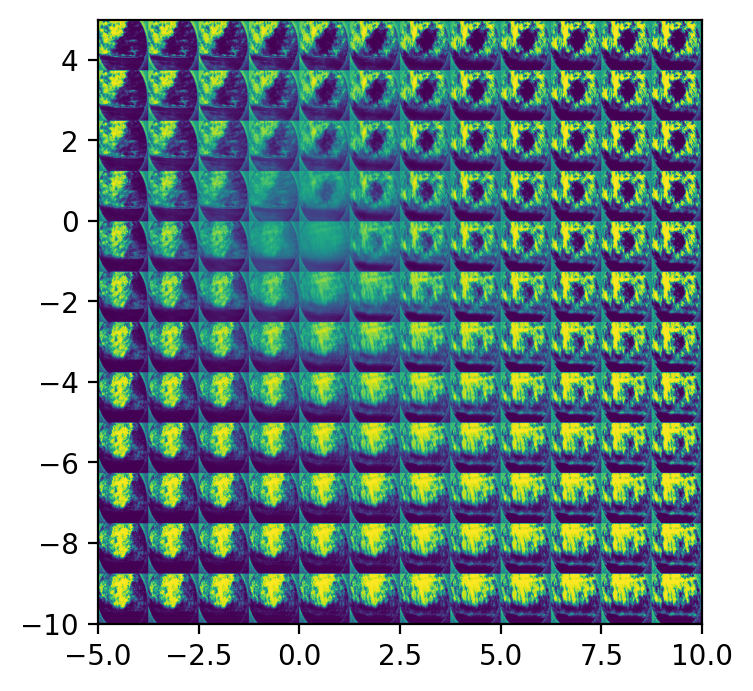

In [14]:
plot_reconstructed(autoencoder)